# Videte Wheel
## Install Requirements

In [1]:
!conda install -y control slycot tqdm

Solving environment: done

# All requested packages already installed.



## Videte Wheel Kinematics
### Basic Definitions

In [2]:
import sympy

# Declare Time
t = sympy.symbols('t')

# Declare Functions
y = sympy.Function('y')(t)
θ = sympy.Function('θ')(t)
ρ = sympy.Function('ρ')(t)
φ = sympy.Function('φ')(t)

# Declare Masses
m_ow, m_ow_rot, m_iw, m_iw_rot, m_m = sympy.symbols('m_ow m_owr m_iw m_iwr m_m')

# Declare Dimensions
l_iw_m, r_1, r_2, r_3, r_m = sympy.symbols('l_iwm r_1 r_2 r_3 r_m')
l_ow_iw = r_2 - r_1

# Declare Gravity
g = sympy.symbols('g')

In [3]:
# Gear ratio
i_gear = r_2 / r_1

# Linking rotation of outer and inner wheel
φ_iw = φ
φ_ow = (1/i_gear) * φ_iw # virtual rotation of outer wheel (outer wheel movement depends on ρ)

ω = φ.diff(t)
ω_iw = ω
ω_ow = φ_ow.diff(t)

ω_ow

r_1*Derivative(φ(t), t)/r_2

In [4]:
# Y positions
y_ow = r_3 + y
y_iw = y_ow - l_ow_iw * sympy.cos(ρ)
y_m = y_iw + l_iw_m * sympy.cos(θ)

# Rotation based x movement
# TODO: Check to be correct
x = r_3 * (φ_ow - ρ)

# X positions
x_ow = x
x_iw = x_ow + l_ow_iw * sympy.sin(ρ)
x_m = x_iw + l_iw_m * sympy.sin(θ)

### State X

In [5]:
state_x = [θ, θ.diff(t), ρ, ρ.diff(t), φ, φ.diff(t)]

state_x

[θ(t),
 Derivative(θ(t), t),
 ρ(t),
 Derivative(ρ(t), t),
 φ(t),
 Derivative(φ(t), t)]

### Potential Energy

In [6]:
V = (m_m * y_m + m_ow * y_ow + m_iw * y_iw) * g

V

g*(m_iw*(r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_m*(l_iwm*cos(θ(t)) + r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_ow*(r_3 + y(t)))

### Kinetic Energy

In [7]:
# Rotating mass inertia
J_ow_rot = (1/2) * m_ow_rot * (r_2**2 + r_3**2)
J_iw_rot = (1/2) * m_iw_rot * r_1**2

# Steinerscher Satz (Gieck M2 & M3)
J_ow = m_ow * l_ow_iw**2 + m_ow * r_2**2
J_m = m_m * l_iw_m**2 + (m_m / 2) * r_m**2

J_iw = J_ow_rot + J_iw_rot

# Kinetic energy of rotating cylinder
W_owr = (1/2) * J_ow_rot * ω_ow**2
W_iwr = (1/2) * J_iw_rot * ω_iw**2

# Translational kinetic energy
W_ow = (1/2) * m_ow * (sympy.diff(x_ow, t)**2 + sympy.diff(y_ow, t)**2)
W_iw = (1/2) * m_iw * (sympy.diff(x_iw, t)**2 + sympy.diff(y_iw, t)**2)
W_m = (1/2) * m_m * (sympy.diff(x_m, t)**2 + sympy.diff(y_m, t)**2)

# Dampening (e.g. heat dissipation)
d_ow, d_iw, d_m, d_owr, d_iwr = sympy.symbols(
    'd_ow d_iw d_m d_owr d_iwr')

W_d_ow = sympy.integrate(
    d_ow * (1/2) * (sympy.diff(x_ow, t)**2 + sympy.diff(y_ow, t)**2), t)
W_d_iw = sympy.integrate(d_iw * (1/2) * sympy.diff(ρ, t)**2, t)
W_d_m = sympy.integrate((d_m * (1/2) * sympy.diff(θ, t)**2), t)
W_d_owr = sympy.integrate(d_owr * (1/2) * ω_ow**2, t)
W_d_iwr = sympy.integrate(d_iwr * (1/2) * ω_iw**2, t)

W_heat = W_d_iw + W_d_m # + W_d_ow + W_d_owr + W_d_iwr

# Kinetic Energy
T = W_ow + W_iw + W_m + W_owr + W_iwr + W_heat

T

0.5*d_iw*Integral(Derivative(ρ(t), t)**2, t) + 0.5*d_m*Integral(Derivative(θ(t), t)**2, t) + 0.5*m_iw*((r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2 + (-(r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2) + 0.25*m_iwr*r_1**2*Derivative(φ(t), t)**2 + 0.5*m_m*((-l_iwm*sin(θ(t))*Derivative(θ(t), t) - (r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2 + (l_iwm*cos(θ(t))*Derivative(θ(t), t) + r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2) + 0.5*m_ow*(r_3**2*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t))**2 + Derivative(y(t), t)**2) + 0.25*m_owr*r_1**2*(r_2**2 + r_3**2)*Derivative(φ(t), t)**2/r_2**2

### Lagrange Equation

In [8]:
L = T - V

L

0.5*d_iw*Integral(Derivative(ρ(t), t)**2, t) + 0.5*d_m*Integral(Derivative(θ(t), t)**2, t) - g*(m_iw*(r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_m*(l_iwm*cos(θ(t)) + r_3 - (-r_1 + r_2)*cos(ρ(t)) + y(t)) + m_ow*(r_3 + y(t))) + 0.5*m_iw*((r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2 + (-(r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2) + 0.25*m_iwr*r_1**2*Derivative(φ(t), t)**2 + 0.5*m_m*((-l_iwm*sin(θ(t))*Derivative(θ(t), t) - (r_1 - r_2)*sin(ρ(t))*Derivative(ρ(t), t) + Derivative(y(t), t))**2 + (l_iwm*cos(θ(t))*Derivative(θ(t), t) + r_3*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t)) + (-r_1 + r_2)*cos(ρ(t))*Derivative(ρ(t), t))**2) + 0.5*m_ow*(r_3**2*(r_1*Derivative(φ(t), t)/r_2 - Derivative(ρ(t), t))**2 + Derivative(y(t), t)**2) + 0.25*m_owr*r_1**2*(r_2**2 + r_3**2)*Derivative(φ(t), t)**2/r_2**2

In [9]:
f_θ = θ.diff(t)
L_θ = sympy.diff(sympy.diff(L, sympy.diff(θ, t)), t) - sympy.diff(L, θ)
f_dθ = sympy.solve(L_θ, θ.diff(t, t))[0]

f_ρ = ρ.diff(t)
L_ρ = sympy.diff(sympy.diff(L, sympy.diff(ρ, t)), t) - sympy.diff(L, ρ)
f_dρ = sympy.solve(L_ρ, ρ.diff(t, t))[0]

f_φ = φ.diff(t)
L_φ = sympy.diff(sympy.diff(L, sympy.diff(φ, t)), t) - sympy.diff(L, φ)
f_dφ = sympy.solve(L_φ, φ.diff(t, t))[0]

In [10]:
f_dθ

-d_m*Derivative(θ(t), t)/(l_iwm**2*m_m) + g*sin(θ(t))/l_iwm - r_1*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2/l_iwm + r_1*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2))/l_iwm - r_1*r_3*cos(θ(t))*Derivative(φ(t), (t, 2))/(l_iwm*r_2) + r_2*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2/l_iwm - r_2*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2))/l_iwm + r_3*cos(θ(t))*Derivative(ρ(t), (t, 2))/l_iwm + sin(θ(t))*Derivative(y(t), (t, 2))/l_iwm

In [11]:
f_dρ

(-d_iw*r_2*Derivative(ρ(t), t) + g*m_iw*r_1*r_2*sin(ρ(t)) - g*m_iw*r_2**2*sin(ρ(t)) + g*m_m*r_1*r_2*sin(ρ(t)) - g*m_m*r_2**2*sin(ρ(t)) - l_iwm*m_m*r_1*r_2*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 + l_iwm*m_m*r_1*r_2*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) + l_iwm*m_m*r_2**2*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 - l_iwm*m_m*r_2**2*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) - l_iwm*m_m*r_2*r_3*sin(θ(t))*Derivative(θ(t), t)**2 + l_iwm*m_m*r_2*r_3*cos(θ(t))*Derivative(θ(t), (t, 2)) + m_iw*r_1**2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_iw*r_1*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_1*r_2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_iw*r_1*r_2*sin(ρ(t))*Derivative(y(t), (t, 2)) + m_iw*r_1*r_3**2*Derivative(φ(t), (t, 2)) - m_iw*r_2**2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_2**2*sin(ρ(t))*Derivative(y(t), (t, 2)) + m_m*r_1**2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_m*r_1*r_2*r_3*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_m*r_1*r_2*r_3*cos(ρ(t))*Derivative(φ(t), (t, 2)) + m_m*r

In [12]:
f_dφ

2.0*r_2*r_3*(l_iwm*m_m*sin(θ(t))*Derivative(θ(t), t)**2 - l_iwm*m_m*cos(θ(t))*Derivative(θ(t), (t, 2)) - m_iw*r_1*sin(ρ(t))*Derivative(ρ(t), t)**2 + m_iw*r_1*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_iw*r_2*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_iw*r_2*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_iw*r_3*Derivative(ρ(t), (t, 2)) - m_m*r_1*sin(ρ(t))*Derivative(ρ(t), t)**2 + m_m*r_1*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_m*r_2*sin(ρ(t))*Derivative(ρ(t), t)**2 - m_m*r_2*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + m_m*r_3*Derivative(ρ(t), (t, 2)) + m_ow*r_3*Derivative(ρ(t), (t, 2)))/(r_1*(2.0*m_iw*r_3**2 + m_iwr*r_2**2 + 2.0*m_m*r_3**2 + 2.0*m_ow*r_3**2 + m_owr*r_2**2 + m_owr*r_3**2))

In [13]:
state_x

[θ(t),
 Derivative(θ(t), t),
 ρ(t),
 Derivative(ρ(t), t),
 φ(t),
 Derivative(φ(t), t)]

In [14]:
eqs = [f_θ, f_dθ, f_ρ, f_dρ, f_φ, f_dφ]

### Create A Matrix

In [15]:
def createMatrix(eqs: list, states: list) -> sympy.Matrix:
    if (len(eqs) != len(states)):
        print("eqs and states must have the same size")
    A = sympy.zeros(len(eqs), len(eqs))
    for i, eq in enumerate(eqs, start=0):
        for j, state in enumerate(states, start=0):
            A[i, j] = sympy.diff(eq, state)
    return A

In [16]:
A = createMatrix(eqs, state_x)

A

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0,                                                                                                                                                                                                                                                                                                                                                                                                   

In [17]:
import math

def linearice(A, x, ddx):
    linearice_values = [
        (sympy.sin(θ), math.sin(x[0])),
        (sympy.cos(θ), math.cos(x[0])),
        (sympy.sin(ρ), math.sin(x[2])),
        (sympy.cos(ρ), math.cos(x[2])),
        (θ.diff(t, t), ddx[0]),
        (θ.diff(t), x[1]),
        (θ, x[0]),
        (ρ.diff(t, t), ddx[1]),
        (ρ.diff(t), x[3]),
        (ρ, x[2]),
        (φ.diff(t, t), ddx[2]),
        (φ.diff(t), x[5]),
        (φ, x[4]),
        # Can't move y position (Could .. but should not ..) 
        (y.diff(t, t), 0),
        (y.diff(t), 0),
        (y, 0)
    ]
    return sympy.simplify(A.subs(linearice_values))

In [18]:
A_lin_up = linearice(A, [0, 0, 0, 0, 0, 0], [0, 0, 0])
A_lin_down = linearice(A, [math.pi, 0, 0, 0, 0, 0], [0, 0, 0])

In [19]:
A_lin_up

Matrix([
[          0,                   1,                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                                   0, 0, 0],
[1.0*g/l_iwm, -d_m/(l_iwm**2*m_m),                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                

In [20]:
A_lin_down

Matrix([
[           0,                   1,                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                                   0, 0, 0],
[-1.0*g/l_iwm, -d_m/(l_iwm**2*m_m),                                                                                                                                                                                                                                                             0,                                                                                                                                                                                              

### Robot Specifications

In [21]:
constants = {
    g: 9.81
}

masses = {
    m_ow: 0.4,
    m_ow_rot: 0.2,
    m_iw: 0.7,
    m_iw_rot: 0.1,
    m_m: 1.0
}

lengths = {
    l_iw_m: 0.08,
    r_1: 0.073 / 2,
    r_2: 0.183 / 2,
    r_3: 0.205 / 2,
    r_m: 0.076 / 2
}

dampening = {
    d_ow: .01,
    d_iw: .01,
    d_m: .01,
    d_owr: .01,
    d_iwr: .01
}

specs = {**constants, **masses, **lengths, **dampening}

specs

{g: 9.81,
 m_ow: 0.4,
 m_owr: 0.2,
 m_iw: 0.7,
 m_iwr: 0.1,
 m_m: 1.0,
 l_iwm: 0.08,
 r_1: 0.0365,
 r_2: 0.0915,
 r_3: 0.1025,
 r_m: 0.038,
 d_ow: 0.01,
 d_iw: 0.01,
 d_m: 0.01,
 d_owr: 0.01,
 d_iwr: 0.01}

### Create Jacobian

In [22]:
import numpy as np

A_j_up = np.float64(sympy.simplify(A_lin_up.subs(specs)))
A_j_down = np.float64(sympy.simplify(A_lin_down.subs(specs)))

In [23]:
sympy.Matrix(A_j_up)

Matrix([
[    0.0,     1.0,               0.0,               0.0, 0.0, 0.0],
[122.625, -1.5625,               0.0,               0.0, 0.0, 0.0],
[    0.0,     0.0,               0.0,               1.0, 0.0, 0.0],
[    0.0,     0.0, -114.110566829951, -1.24407122307752, 0.0, 0.0],
[    0.0,     0.0,               0.0,               0.0, 0.0, 1.0],
[    0.0,     0.0,               0.0,               0.0, 0.0, 0.0]])

In [24]:
sympy.Matrix(A_j_down)

Matrix([
[     0.0,     1.0,               0.0,               0.0, 0.0, 0.0],
[-122.625, -1.5625,               0.0,               0.0, 0.0, 0.0],
[     0.0,     0.0,               0.0,               1.0, 0.0, 0.0],
[     0.0,     0.0, -114.110566829951, -1.24407122307752, 0.0, 0.0],
[     0.0,     0.0,               0.0,               0.0, 0.0, 1.0],
[     0.0,     0.0,               0.0,               0.0, 0.0, 0.0]])

### Design B Matrix

Single motor input (treating both sides of the robot the same)

In [25]:
# All rotating mass inertia for input
J_in_all = J_iw + J_ow + J_m

ddθ_in_ratio = (J_ow + J_iw) / (2 * J_in_all)

ddρ_in_ratio = (J_m + J_iw) / (2 * J_in_all)

ddφ_in_ratio = (J_ow + J_m) / (2 * J_in_all)

B = np.float64(sympy.Matrix([0, -1 * ddθ_in_ratio, 0, ddρ_in_ratio, 0, ddφ_in_ratio]).subs(specs))

sympy.Matrix(B)

Matrix([
[               0.0],
[-0.238840826564017],
[               0.0],
[ 0.332828060126748],
[               0.0],
[ 0.428331113309235]])

In [26]:
sympy.simplify(ddθ_in_ratio + ddρ_in_ratio + ddφ_in_ratio)

1

### Check Controllability

In [27]:
import control
import numpy.linalg as linalg

C_up = control.ctrb(A_j_up, B)
C_down = control.ctrb(A_j_down, B)

rank_up = linalg.matrix_rank(C_up)
rank_down = linalg.matrix_rank(C_down)

print("Rank C up matrix:   " + str(rank_up) + " for " + str(C_up.shape) + " matrix")
print("Rank C down matrix: " + str(rank_down) + " for " + str(C_down.shape) + " matrix")

Rank C up matrix:   6 for (6, 6) matrix
Rank C down matrix: 6 for (6, 6) matrix


In [28]:
# sympy.Matrix(control.obsv(A_j_up, C_up))

In [29]:
# sympy.Matrix(control.obsv(A_j_down, C_down))

### Design Cost Matrix Q and R

* Choosen simple default vaules
* Optimize here in future

In [30]:
Q = np.float64(np.diag([5, 1, 1, 4, 2, 1]))
R = np.float64([0.1])

In [31]:
sympy.Matrix(Q)

Matrix([
[5.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 4.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 2.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [32]:
sympy.Matrix(R)

Matrix([[0.1]])

### Print Shapes

In [33]:
print("A_down: " + str(A_j_down.shape) + ", A_up: " + str(A_j_up.shape) + ", B: " + str(B.shape) + ", Q: " + str(Q.shape) + ", R: " + str(R.shape))

A_down: (6, 6), A_up: (6, 6), B: (6, 1), Q: (6, 6), R: (1,)


## Generate LQR Controller

In [34]:
K, S, E = control.lqr(A_j_up, B, Q, R)

K_up = np.float64(K)

sympy.Matrix(K_up)

Matrix([[-1349.48148159623, -113.610461839415, 35.2413446664396, -0.429201933143233, -4.47213595499704, -6.46977204780747]])

In [35]:
K_up

matrix([[-1.34948148e+03, -1.13610462e+02,  3.52413447e+01,
         -4.29201933e-01, -4.47213595e+00, -6.46977205e+00]])

In [36]:
K, S, E = control.lqr(A_j_down, B, Q, R)

K_down = np.float64(K)

sympy.Matrix(K_down)

Matrix([[-1.74018903066308, -0.528195264856022, 7.86287345981553, 3.44075409661961, 4.47213595499958, 5.60636684746675]])

## Simulation

### Uncontrolled Pendulum Simulation

#### Initial Values

In [37]:
import math

dt = 0.01
timeline = np.arange(0., 10., dt)

offset = 0.1
θ_up_0 = offset
θ_down_0 = math.pi + offset

x_0_up = np.float64([θ_up_0, 0, 0, 0, 0, 0])
x_0_down = np.float64([θ_down_0, 0, 0, 0, 0, 0])

In [38]:
sympy.Matrix(x_0_up)

Matrix([
[0.1],
[0.0],
[0.0],
[0.0],
[0.0],
[0.0]])

In [39]:
sympy.Matrix(x_0_down)

Matrix([
[3.24159265358979],
[             0.0],
[             0.0],
[             0.0],
[             0.0],
[             0.0]])

#### Simulation via A matrix

In [40]:
import scipy.integrate as integrate

def apply(y, t):
    return A_local @ y

A_local = A_j_up
solution_up_lin = integrate.odeint(apply, x_0_up, timeline)

A_local = A_j_down
solution_down_lin = integrate.odeint(apply, x_0_down, timeline)

#### Simulation via differential equations

In [41]:
f_θ_c = f_θ.subs(specs)
f_dθ_c = f_dθ.subs(specs)
f_ρ_c = f_ρ.subs(specs)
f_dρ_c = f_dρ.subs(specs)
f_φ_c = f_φ.subs(specs)
f_dφ_c = f_dφ.subs(specs)

In [42]:
f_dθ_c

0.6875*sin(θ(t) + ρ(t))*Derivative(ρ(t), t)**2 + 12.5*sin(θ(t))*Derivative(y(t), (t, 2)) + 122.625*sin(θ(t)) - 0.6875*cos(θ(t) + ρ(t))*Derivative(ρ(t), (t, 2)) + 1.28125*cos(θ(t))*Derivative(ρ(t), (t, 2)) - 0.511099726775956*cos(θ(t))*Derivative(φ(t), (t, 2)) - 1.5625*Derivative(θ(t), t)

In [43]:
f_dρ_c

10.9289617486339*(0.0004026*sin(θ(t) + ρ(t))*Derivative(θ(t), t)**2 - 0.0007503*sin(θ(t))*Derivative(θ(t), t)**2 - 0.00855525*sin(ρ(t))*Derivative(y(t), (t, 2)) - 0.000876913125*sin(ρ(t))*Derivative(ρ(t), t)**2 - 0.0839270025*sin(ρ(t)) - 0.0004026*cos(θ(t) + ρ(t))*Derivative(θ(t), (t, 2)) + 0.0007503*cos(θ(t))*Derivative(θ(t), (t, 2)) - 0.000349806875*cos(ρ(t))*Derivative(φ(t), (t, 2)) - 0.000915*Derivative(ρ(t), t) + 0.0008053040625*Derivative(φ(t), (t, 2)))/(0.027205625 - 0.0191675*cos(ρ(t)))

In [44]:
f_dφ_c

0.843517124923089*sin(θ(t))*Derivative(θ(t), t)**2 + 0.98586063975386*sin(ρ(t))*Derivative(ρ(t), t)**2 - 0.843517124923089*cos(θ(t))*Derivative(θ(t), (t, 2)) - 0.98586063975386*cos(ρ(t))*Derivative(ρ(t), (t, 2)) + 2.26958826424619*Derivative(ρ(t), (t, 2))

In [45]:
precision = 2

ddx = [0,0,0]

def update_ddx(ddx_in):
    ddx = ddx_in

def apply_deq(y, t):
    ret = np.zeros(6)
    ret[0] = y[1]
    ret[2] = y[3]
    ret[4] = y[5]

    for _ in range(precision):
        ret[1] = linearice(f_dθ_c, y, ddx)
        ret[3] = linearice(f_dρ_c, y, ddx)
        ret[5] = linearice(f_dφ_c, y, ddx)
        update_ddx([ret[1], ret[3], ret[5]])
    return ret

update_ddx([0,0,0])
solution_up_deq = integrate.odeint(apply_deq, x_0_up, timeline, mxstep=30)

update_ddx([0,0,0])
solution_down_deq = integrate.odeint(apply_deq, x_0_down, timeline, mxstep=30)

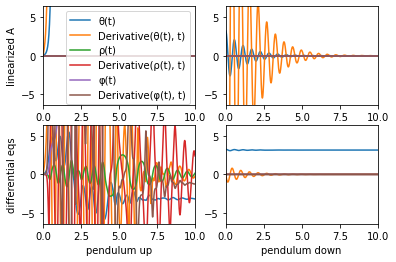

Uncontrolled Pendulum


In [46]:
%matplotlib inline

import matplotlib.pyplot as plt

states = state_x
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])


axs[0,0].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Uncontrolled Pendulum")

### Controlled Pendulum Simulation

#### Initial Values

In [47]:
dt = 0.01
timeline = np.arange(0., 20., dt)

offset = 0.1
θ_up_0 = offset
θ_down_0 = math.pi + offset

x_0_up = np.float64([θ_up_0, 0, 0.3, 0, 0, 0])
x_0_down = np.float64([θ_down_0, 0, 0.3, 0, 0, 0])

#### Control of A Matrix

In [48]:
def apply_k(y_k, t):
    w = np.float64([0, 0, 0, 0, 0, 0])
    if (t > 5):
        w = np.float64([0, 0, 0, 0, 1, 0])
    if (t > 18):
        w = np.float64([0, 0, 0, 0, 0, 0])
    return A_local @ y_k - np.array(B) * np.array(K) @ y_k - w

A_local = A_j_up
K = K_up

solution_up_lin_k = integrate.odeint(apply_k, x_0_up, timeline)

A_local = A_j_down
K = K_down

solution_down_lin_k = integrate.odeint(apply_k, x_0_down, timeline)

#### Control of diffential equations

In [49]:
def apply_deq_k(y_k, t):
    retA = apply_deq(y_k, t)
    w = np.float64([0, 0, 0, 0, 0, 0])
    if (t > 5):
        w = np.float64([0, 0, 0, 0, 1, 0])
    if (t > 18):
        w = np.float64([0, 0, 0, 0, 0, 0])
    retK = np.array(B) * np.array(K) @ y_k - w
    return retA - retK

K = K_up
solution_up_deq_k = integrate.odeint(apply_deq_k, x_0_up, timeline)

K = K_down
solution_down_deq_k = integrate.odeint(apply_deq_k, x_0_down, timeline)

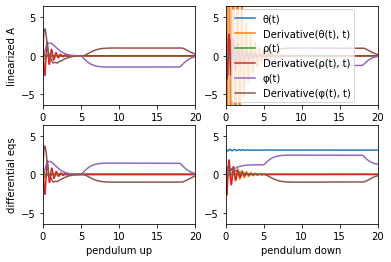

Controlled Pendulum


In [50]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].axis([-0.01, timeline[-1] + 0.01, -(math.pi * 2 + 0.1), math.pi * 2 + 0.1])

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Controlled Pendulum")

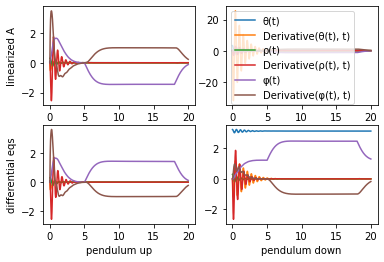

Controlled Pendulum (free axis range)


In [51]:
fig, axs = plt.subplots(2, 2)

for row, state in enumerate(states):
    axs[0, 0].plot(timeline, solution_up_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[0, 1].plot(timeline, solution_down_lin_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 0].plot(timeline, solution_up_deq_k[:, row], label=str(state))

for row, state in enumerate(states):
    axs[1, 1].plot(timeline, solution_down_deq_k[:, row], label=str(state))

axs[0,1].legend()
axs[0,0].set_ylabel("linearized A")
axs[1,0].set_ylabel("differential eqs")
axs[1,0].set_xlabel("pendulum up")
axs[1,1].set_xlabel("pendulum down")

plt.show()

print("Controlled Pendulum (free axis range)")

In [52]:
import tqdm

def getPositions(solution):
    # x_ow, y_ow, x_iw, y_iw, x_m, y_m
    positions = sympy.zeros(6, len(solution))
    control = sympy.zeros(1, len(solution))

    for tp in tqdm.tqdm(range(len(solution))):
        results = {
            (θ.diff(t, t), 0),
            (θ.diff(t), solution[tp, 1]),
            (θ, solution[tp, 0]),
            (ρ.diff(t, t), 0),
            (ρ.diff(t), solution[tp, 3]),
            (ρ, solution[tp, 2]),
            (φ.diff(t, t), 0),
            (φ.diff(t), solution[tp, 5]),
            (φ, solution[tp, 4]),
            (y.diff(t, t), 0),
            (y.diff(t), 0),
            (y, 0)
        }
        positions[0, tp] = x_ow.subs(specs).subs(results)
        positions[1, tp] = y_ow.subs(specs).subs(results)
        positions[2, tp] = x_iw.subs(specs).subs(results)
        positions[3, tp] = y_iw.subs(specs).subs(results)
        positions[4, tp] = x_m.subs(specs).subs(results)
        positions[5, tp] = y_m.subs(specs).subs(results)
        w = np.float64([0, 0, 0, 0, 0, 0])
        if ((tp * dt) > 5):
            w = np.float64([0, 0, 0, 0, 1, 0])
        if ((tp * dt) > 18):
            w = np.float64([0, 0, 0, 0, 0, 0])
        control[0, tp] = -K.dot(solution[tp, :] - w)
    return positions, control

positions_up, control_up = getPositions(solution_up_deq)
positions_down, control_down = getPositions(solution_down_deq)

positions_up_k, control_up_k = getPositions(solution_up_deq_k)
positions_down_k, control_down_k = getPositions(solution_down_deq_k)

100%|██████████| 2000/2000 [01:17<00:00, 25.84it/s]


In [53]:
solution = solution_down_deq
positions = positions_down
control = control_down

In [54]:
solution = solution_up_deq
positions = positions_up
control = control_up

In [55]:
solution = solution_down_deq_k
positions = positions_down_k
control = control_down_k

In [56]:
solution = solution_up_deq_k
positions = positions_up_k
control = control_up_k

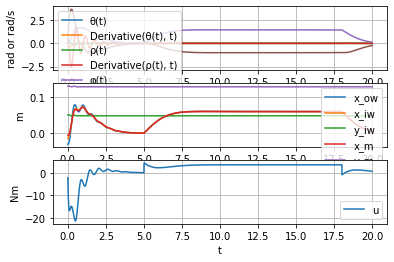

In [57]:
fig, axs = plt.subplots(3)

for row, state in enumerate(states):
    axs[0].plot(timeline, solution[:, row], label=str(state))

axs[1].plot(timeline, positions[0, :].T, label='x_ow')
# axs[1].plot(timeline, positions[1, :].T, label='y_ow')
axs[1].plot(timeline, positions[2, :].T, label='x_iw')
axs[1].plot(timeline, positions[3, :].T, label='y_iw')
axs[1].plot(timeline, positions[4, :].T, label='x_m')
axs[1].plot(timeline, positions[5, :].T, label='y_m')

axs[2].plot(timeline, control[0, :].T, label='u')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].set_ylabel('rad or rad/s')
axs[1].set_ylabel('m')
axs[2].set_ylabel('Nm')

axs[2].set_xlabel('t')

plt.show()

### Robot Animation

In [58]:
import time

import numpy as np
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool, Range
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [59]:
x_dots = np.float64([0,0,0])
y_dots = np.float64([0,0,0])

c_ow = float(r_3.subs(specs))
c_iw = float(r_1.subs(specs))
c_m = float(r_1.subs(specs))

radii = [c_ow, c_iw, c_m]
colors = ["#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x_dots, 30+2*y_dots)]

radii

[0.1025, 0.0365, 0.0365]

In [60]:
TOOLS="crosshair,pan,wheel_zoom,box_zoom,reset,tap,box_select,lasso_select"

p = figure(tools=TOOLS, x_range = [-0.1,0.4], y_range = [-0.1,0.4])
p.axis.major_label_text_font_size = "24px"
hover = HoverTool(tooltips=None, mode="vline")
p.add_tools(hover)
r = p.circle(x_dots, y_dots, radius=radii, 
             fill_color=colors, fill_alpha=0.6, line_color=None,
             hover_fill_color="black", hover_fill_alpha=0.7, hover_line_color=None)

In [61]:
# get and explicit handle to update the next show cell with
target = show(p, notebook_handle=True)

In [62]:
i = 0
for tp in range(len(timeline)):
    i +=1 
    p.title.text = str(i)

    r.data_source.data['x'] = np.array([float(positions[0, tp]), float(positions[2, tp]), float(positions[4, tp]) ])
    r.data_source.data['y'] = np.array([float(positions[1, tp]), float(positions[3, tp]), float(positions[5, tp]) ])

    # push updates to the plot continuously using the handle (intererrupt the notebook kernel to stop)
    push_notebook(handle=target)
    time.sleep(dt * 5)